In [1]:
from qiskit import *
import matplotlib.pyplot as plt
from qiskit import Aer
from qiskit.quantum_info import partial_trace, Statevector
import numpy as np

In [2]:
def encoded_state(sv):
    # traces out ancilla qubits

    # full_statevector = Statevector(cir)
    partial_dm = partial_trace(sv, [5, 6, 7, 8])
    partial_sv = np.diagonal(partial_dm)

    return partial_sv

In [3]:
def stabilizer_measurements(qr, cr):
    gens = [
        ['x','z','z','x','i'],
        ['i','x','z','z','x'],
        ['x','i','x','z','z'],
        ['z','x','i','x','z']
    ]

    cir = QuantumCircuit(qr, cr)
    
    for i, s in enumerate(gens):
        cir.h(i+5)
        for j, g in enumerate(s):
            if (g == 'x'):
                cir.cnot(i+5, j)
            elif (g == 'z'):
                cir.cz(i+5, j)
            else:
                pass
        cir.h(i+5)
        cir.measure(i+5,i)
        # cir.reset(i+5)

    return cir

def encoding(qr):
    cir = QuantumCircuit(qr)

    cir.h(0)
    cir.s(0)
    cir.cz(0,1)
    cir.cz(0,3)
    cir.cy(0,4)

    cir.h(1)
    cir.cz(1,2)
    cir.cz(1,3)
    cir.cx(1,4)

    cir.h(2)
    cir.cz(2,0)
    cir.cz(2,1)
    cir.cx(2,4)

    cir.h(3)
    cir.s(3)
    cir.cz(3,0)
    cir.cz(3,2)
    cir.cy(3,4)
    
    return cir

def error_correction(qr, syn):
    # syn in the error syndrome returned from measuring the stabilizers
    # cir.id(0).c_if(syn, 0)
    cir = QuantumCircuit(qr, syn)

    cir.x(0).c_if(syn, 8) # 8 or 1
    cir.y(0).c_if(syn, 13) # 13 or 11
    cir.z(0).c_if(syn, 5) # 5 or 10

    cir.x(1).c_if(syn, 1) # 1 or 8
    cir.y(1).c_if(syn, 11) # 11 or 13
    cir.z(1).c_if(syn, 10) # 10 or 5

    cir.x(2).c_if(syn, 3) # 3 or 12
    cir.y(2).c_if(syn, 7) # 7 or 14
    cir.z(2).c_if(syn, 4) # 4 or 2

    cir.x(3).c_if(syn, 6)
    cir.y(3).c_if(syn, 15)
    cir.z(3).c_if(syn, 9)

    cir.x(4).c_if(syn, 12) # 12 or 3
    cir.y(4).c_if(syn, 14) # 14 or 7
    cir.z(4).c_if(syn, 2) # 2 or 4

    return cir

In [32]:
from qiskit.test.mock import FakeSantiago
from qiskit import QuantumCircuit
from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer import extensions  # import aer snapshot instructions
from qiskit import execute
sim_santiago = AerSimulator.from_backend(FakeSantiago())

qc = QuantumCircuit(1)
for i in range(1000):
    qc.x(0)
# qc.cnot(0,1)
qc.snapshot_statevector('1')
circ_thermal = transpile(qc, sim_santiago)
result = execute(circ_thermal, sim_santiago).result()
# Extract density matrix snapshot from result object:
density_matrix = result.data()['snapshots']['statevector']['1'][0]
print(density_matrix)

[1.+0.j 0.+0.j]


In [150]:
q = QuantumRegister(9)
c = ClassicalRegister(5)
cir = QuantumCircuit(q, c)


# cir.h(4)
cir += encoding(q)
# x
# cir.x([0,1,2,3,4])

# y
# cir.y([0,1,2,3,4])

# h
cir.h([0,1,2,3,4])
cir.swap(0, 1)
cir.swap(3, 4)
cir.swap(1, 3)

# s
# cir.s([0,1,2,3,4])
# cir.s([0,1,2,3,4])

# s dag
# cir.sdg([0,1,2,3,4])
# cir.sdg([0,1,2,3,4])
cir += stabilizer_measurements(q, c)

cir += error_correction(q, c)

cir += encoding(q).inverse() # decoding

cir.measure([0,1,2,3,4],[0,1,2,3,4])
# cir.snapshot_statevector('1')
cir.draw()

┌───┐┌───┐                                                ┌───┐     »
q2337_0: ┤ H ├┤ S ├─■──■────────■────────────────────■───────────■─┤ H ├──X──»
         └───┘└───┘ │  │ ┌───┐  │                    │     ┌───┐ │ └───┘  │  »
q2337_1: ───────────■──┼─┤ H ├──┼───■──■────────■────┼───■─┤ H ├─┼────────X──»
                       │ └───┘  │   │  │ ┌───┐  │    │   │ └───┘ │      ┌───┐»
q2337_2: ──────────────┼────────┼───■──┼─┤ H ├──┼────■───■───■───┼───■──┤ H ├»
                       │        │      │ ├───┤  │  ┌───┐     │   │   │  └───┘»
q2337_3: ──────────────■────────┼──────■─┤ H ├──┼──┤ S ├─────┼───■───■────■──»
                              ┌─┴─┐      └───┘┌─┴─┐└───┘   ┌─┴─┐        ┌─┴─┐»
q2337_4: ─────────────────────┤ Y ├───────────┤ X ├────────┤ X ├────────┤ Y ├»
         ┌───┐                └───┘           └───┘        └───┘        └───┘»
q2337_5: ┤ H ├───────────────────────────────────────────────────────────────»
         ├───┤                                                               »
q2337_6: ┤ H ├───────────────────────────────────────────────────────────────»
         ├───┤                                                               »
q2337_7: ┤ H ├───────────────────────────────────────────────────────────────»
         ├───┤                                                               »
q2337_8: ┤ H ├───────────────────────────────────────────────────────────────»
         └───┘                                                               »
  c35: 5/════════════════════════════════════════════════════════════════════»
                                                                             »
«              ┌───┐   ┌───┐                                                   »
«q2337_0: ─────┤ X ├───┤ X ├────■──────────────────────────────────────────────»
«              └─┬─┘   └─┬─┘    │       ┌───┐        ┌───┐                     »
«q2337_1: ───────┼───────┼───X──┼──■────┤ X ├────────┤ X ├─────────────────────»
«                │       │   │  │  │    └─┬─┘        └─┬─┘        ┌───┐        »
«q2337_2: ───────┼───────┼───┼──┼──┼──■───┼────────■───┼──────────┤ X ├────────»
«         ┌───┐  │       │   │  │  │  │   │  ┌───┐ │   │          └─┬─┘        »
«q2337_3: ┤ H ├──┼───X───┼───X──┼──┼──┼───┼──┤ X ├─┼───┼────────■───┼──────────»
«         ├───┤  │   │   │      │  │  │   │  └─┬─┘ │   │        │   │     ┌───┐»
«q2337_4: ┤ H ├──┼───X───┼──────┼──┼──┼───┼────┼───┼───┼────────┼───┼─────┤ X ├»
«         └───┘  │       │      │  │  │   │    │   │   │  ┌───┐ │   │  ┌─┐└─┬─┘»
«q2337_5: ───────■───────┼──────┼──■──■───┼────■───┼───┼──┤ H ├─┼───┼──┤M├──┼──»
«                        │      │         │        │   │  └───┘ │   │  └╥┘  │  »
«q2337_6: ───────────────┼──────┼─────────■────────■───┼────────■───┼───╫───■──»
«                        │      │                      │            │   ║      »
«q2337_7: ───────────────■──────┼──────────────────────┼────────────■───╫──────»
«                               │                      │                ║      »
«q2337_8: ──────────────────────■──────────────────────■────────────────╫──────»
«                                                                       ║      »
«  c35: 5/══════════════════════════════════════════════════════════════╩══════»
«                                                                       0      »
«                                                ┌───┐  ┌───┐   ┌───┐        »
«q2337_0: ───────────────────────────────────────┤ X ├──┤ Y ├───┤ Z ├────────»
«                                                └─╥─┘  └─╥─┘   └─╥─┘  ┌───┐ »
«q2337_1: ─────────────────────────────────────────╫──────╫───────╫────┤ X ├─»
«                                                  ║      ║       ║    └─╥─┘ »
«q2337_2: ─────────────────────────────────────────╫──────╫───────╫──────╫───»
«                    ┌───┐                         ║      ║       ║      ║   »
«q2337_3: ─■─────────┤ X ├─────────────────────────╫──────╫───────╫──────╫───»
«          │     

In [151]:
backend = Aer.get_backend('statevector_simulator')
job_sim = backend.run(transpile(cir, backend), shots=10000)
result_sim = job_sim.result()
counts = result_sim.get_counts(cir)
sv = result_sim.get_statevector(cir, decimals=3)


{'11100': 63, '01011': 38, '00001': 68, '11000': 40, '10000': 253, '00110': 67, '11001': 46, '00000': 248, '01001': 46, '01010': 42, '00111': 63, '10011': 54, '10110': 64, '00010': 53, '00011': 76, '10100': 50, '10111': 77, '11101': 29, '01111': 57, '01100': 72, '01110': 41, '10001': 79, '11011': 42, '11111': 66, '11010': 41, '10101': 42, '11110': 34, '00100': 32, '01000': 47, '10010': 41, '00101': 41, '01101': 36}


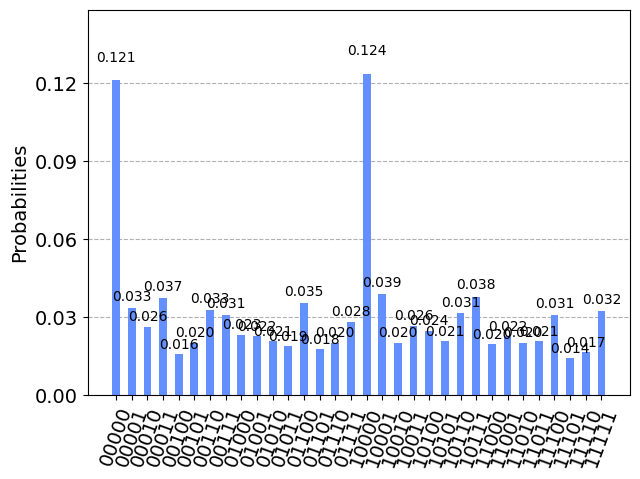

In [154]:
from qiskit import IBMQ, transpile
from qiskit import QuantumCircuit
from qiskit.providers.aer import AerSimulator
from qiskit.tools.visualization import plot_histogram
from qiskit.test.mock import FakeMontreal
device_backend = FakeMontreal()
sim_vigo = AerSimulator.from_backend(device_backend)

tcirc = transpile(cir, sim_vigo)

# Execute noisy simulation and get counts
result_noise = sim_vigo.run(tcirc, shots=2048).result()
counts_noise = result_noise.get_counts(0)
print(counts_noise)
# snapshots = result_noise.data()['snapshots']['statevector']
# print(snapshots['1'][0])
plot_histogram(counts_noise)

In [69]:
print(counts)
# for i, s in enumerate(encoded_state(sv)):
for i, s in enumerate(sv):
    print('{:05b}'.format(i), s)
    # print(i)

{'0000': 1}
00000 0j
00001 0j
00010 0j
00011 0j
00100 0j
00101 0j
00110 0j
00111 0j
01000 0j
01001 0j
01010 0j
01011 0j
01100 0j
01101 0j
01110 0j
01111 0j
10000 (1-0j)
10001 (-0+0j)
10010 -0j
10011 (-0+0j)
10100 (-0-0j)
10101 0j
10110 (-0-0j)
10111 (-0+0j)
11000 -0j
11001 (-0-0j)
11010 (-0+0j)
11011 (-0-0j)
11100 -0j
11101 (-0-0j)
11110 -0j
11111 0j
